In [7]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  1 13:50:59 2019

@author: Luke
"""

import pystan
import matplotlib
import scipy
import pandas as pd
from sklearn import preprocessing, datasets, linear_model, metrics
import numpy as np  

# simple FE practice
df = pd.DataFrame({"Player": [1,2,2,3,1,2,3,4],'Course': [1,1,2,2,3,3,3,3], 'Score':  [75,74,72,71,68,68,71,70]})
#simple reg practice
df2 = pd.DataFrame({"Skill": [4,3,5,8,1,18,20,4,9,8,7], 'Distance': [41,23,35,48,51,18,20,14,29,38,47]})

# transforms into labels starting at 0
le = preprocessing.LabelEncoder()
players = le.fit_transform(df['Player'])
print(players+1)
courses = le.fit_transform(df['Course'])

[1 2 2 3 1 2 3 4]


In [4]:
# model from Stephen Jesse paper

working_model = """
data {
  int<lower=0> N;
  int<lower=0> nplayers;
  int<lower=0> nholes;
  vector[N] score;
  int<lower=1, upper=nplayers> playerid[N];
  int<lower=1, upper=nholes> holeid[N];
}
parameters {
    vector[nplayers] p;
    vector[nholes] c;
    real sigma_p;
    real sigma_c;
    real sigma;
    real<lower=0> constant;
}
transformed parameters {
    vector[N] score_hat;
    vector[nplayers] s_p;
    vector[nholes] s_c;
    real pmean;
    real psd;
    real cmean;
    real csd;
    
    pmean = mean(p);
    psd = sd(p);
    
    cmean = mean(c);
    csd = sd(c);
    
    for (i in 1:N){
        score_hat[i] = constant + p[playerid[i]] + c[holeid[i]];
	}
	
    for(i in 1:nplayers){
	s_p[i] = (p[i] - pmean) / psd;
   }
   
   for(i in 1:nholes){
	s_c[i] = (c[i] - cmean) / csd;
   }
}

model {
    p ~ normal(0, sigma_p);
    c ~ normal(0, sigma_c);
    sigma_p ~ cauchy(0,5);
    sigma_c ~ cauchy(0,5);
    sigma ~ normal(0,20);
    score ~ normal(score_hat, sigma);
    
    
}
"""


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67d40a4bae1e9cd88826bad9b7f24d1d NOW.


Inference for Stan model: anon_model_67d40a4bae1e9cd88826bad9b7f24d1d.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]           -0.1    0.03   1.05  -2.52  -0.41-5.9e-3   0.23   2.03    993    1.0
p[2]          -0.11    0.04   1.05  -2.42  -0.42  -0.04   0.17   2.11    789   1.01
p[3]           0.15    0.04   1.15   -2.1  -0.21 3.8e-3   0.46   2.76    869   1.01
p[4]           0.11    0.04   1.18  -2.34  -0.24   0.02   0.43   2.63   1007    1.0
c[1]           1.78     0.5   2.25  -2.22   0.15   1.65   3.18    6.5     21   1.09
c[2]          -0.22    0.08   1.99  -4.71  -0.98  -0.16   0.63   3.55    575    1.0
c[3]          -2.01    0.09   2.01  -6.67  -2.87  -1.71  -1.04    1.6    453   1.01
sigma_p        1.09    0.22   1.28   0.03    0.2    0.7   1.49   4.43     35   1.07
sigma_c        2.98    0.64   2.45   0.64    1.2   2.44

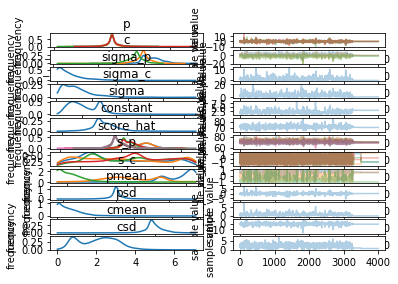

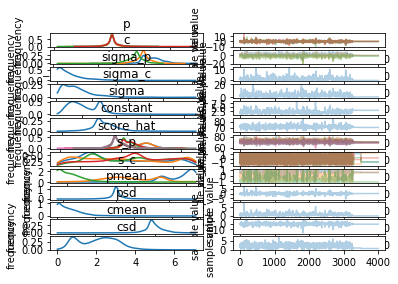

In [8]:
# running stephen's model

working_data = {    'N': len(df['Score']),
                     'nplayers': len(df['Player'].unique()) ,
                     'nholes': len(df['Course'].unique()),
                     'score': df['Score'],
                    'playerid': players+1,
                    'holeid': courses+1
            }

working_fit = pystan.stan(model_code=working_model, data=working_data, iter = 4000, chains=2)

working_la = working_fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = working_fit.extract(permuted=False)
print(working_fit)
working_fit.plot()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67d40a4bae1e9cd88826bad9b7f24d1d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_67d40a4bae1e9cd88826bad9b7f24d1d.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]              15.52    0.04   1.01  13.51  14.84  15.53  16.21  17.44    693    1.0
p[2]               9.72    0.04   1.02    7.7   9.04   9.74  10.39  11.74    668    1.0
p[3]               2.93    0.04    1.0   0.94   2.27   2.92    3.6   4.92    620    1.0
p[4]               2.41    0.04   1.01   0.41   1.74   2.39   3.08   4.39    652    1.0
p[5]               2.91    0.04   1.03   0.89   2.21   2.93   3.63    4.9    666    1.0
p[6]               2.17    0.04   1.05   0.17   1.41   2.14   2.93   4.19    703    1.0
p[7]               2.13    0.04   1.02   0.09   1.45   2.14   2.81   4.11    678    1.0
p[8]                1.0    0.04   0.97  -0.88   0.35   1.01   1.67   2.88    623    1.0
p[9]               

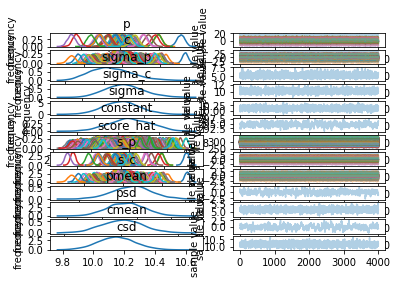

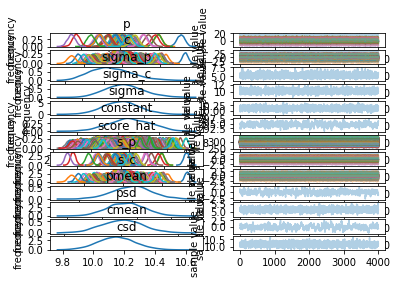

In [18]:
# THIS ONE running stephen's model on big data

stephen_data2 = {    'N': len(bigData['Distance']),
                     'nplayers': len(bigData['Player'].unique()) ,
                     'nholes': len(bigData['Hole'].unique()),
                     'score': bigData['Distance'],
                    'playerid': players1+1,
                    'holeid': holes+1
            }

fit3 = pystan.stan(model_code=stephen_revised_code2, data=stephen_data2, iter = 4000, chains=2)

la3 = fit3.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit3.extract(permuted=False)
print(fit3)
fit3.plot()

In [2]:
# creating linear regression data

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = df2['Skill'].values.reshape(-1,1)
y = df2['Distance'].values.reshape(-1,1)

regressor = LinearRegression()  
regressor.fit(X,y ) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)


[41.02191436]
[[-1.00277078]]


In [3]:
# simple linear regression practice

practice_code = """
data {
    int<lower=0> N; 
  vector[N] skill;
  vector[N] dist;
}
transformed data {}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
transformed parameters {
     }   
model {
       sigma ~ normal(0,5);
    
    dist ~ normal(beta[1] + beta[2]*skill, sigma);
}
"""

practice_data = {    'N': len(df2['Skill']),
                     'skill': df2['Skill'],
                     'dist': df2['Distance']
            }

fit = pystan.stan(model_code=practice_code, data=practice_data, iter=1000, chains=2)

print("test")
la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)
fit.plot()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_045e6c7b4a739a8c71dd8f5638ce9179 NOW.


test
Inference for Stan model: anon_model_045e6c7b4a739a8c71dd8f5638ce9179.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   41.2    0.27   5.75  30.58  37.44  41.21  44.82  52.76    452    1.0
beta[2]  -1.03    0.03   0.59  -2.18  -1.41  -1.02  -0.66   0.14    432   1.01
sigma    10.83    0.08   1.85    7.7   9.46  10.64  11.99  14.81    538    1.0
lp__    -33.37    0.06   1.28 -36.62 -33.99 -33.06 -32.39 -31.86    404    1.0

Samples were drawn using NUTS at Mon Nov 11 10:44:57 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<Figure size 640x480 with 4 Axes>

In [2]:
# best working example on the simple data created above. Seems to get around the problem of the dummy variable trap

ml_code = """
data {
    int<lower=0> N; 
  int<lower=1,upper=4> players[N];
  int<lower=1,upper=3> course[N];
  vector[N] dist;
}
transformed data {}
parameters {
    vector<lower=-1,upper=7>[3] p;
    vector<lower=-7,upper=1>[2] c;
    real<lower=0> constant;
    real<lower=0> sigma;
}
transformed parameters {
   vector[N] y_hat;
  for (i in 1:N){
      if (players[i]==1 && course[i]==1){
          y_hat[i] <- constant;
      }
      else if (players[i]==1){
          y_hat[i] <- constant + c[course[i]-1];
      }
      else if (course[i]==1){
          y_hat[i] <- constant + p[players[i]-1];
      }
      else{
    y_hat[i] <- constant + c[course[i]-1]+ p[players[i]-1];
     }
    }
     }   
model {
       sigma ~ normal(0,1);
    
    dist ~ normal(y_hat, sigma);
}
"""

ml_data = {    'N': len(df['Score']),
             'players': players + 1 ,
             'course': courses + 1,
             'dist': df['Score']
            }

fit = pystan.stan(model_code=ml_code, data=ml_data, iter=4000, chains=2)

la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)
fit.plot()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2ed25d6cee4f1564e93ab2c96c0b133a NOW.


test
Inference for Stan model: anon_model_2ed25d6cee4f1564e93ab2c96c0b133a.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]       0.55    0.02   1.01  -0.89  -0.21   0.39   1.12   2.92   1987    1.0
p[2]       1.68    0.03   1.29  -0.51   0.81   1.56   2.39   4.58   2024    1.0
p[3]       1.78    0.03   1.45  -0.58   0.77   1.62   2.64   5.12   2257    1.0
c[1]      -3.58    0.03    1.3  -6.06  -4.45  -3.62  -2.77  -0.84   2439    1.0
c[2]       -5.6    0.02   0.94  -6.94  -6.31  -5.75  -5.06  -3.46   2361    1.0
constant  73.97    0.02   1.01   71.7  73.36  74.07  74.66  75.73   1747    1.0
sigma       1.3  9.8e-3   0.39   0.73   1.02   1.24   1.52   2.22   1579    1.0
y_hat[1]  73.97    0.02   1.01   71.7  73.36  74.07  74.66  75.73   1747    1.0
y_hat[2]  74.52    0.02   0.94  72.59  73.93  74.53  75.13  76.32   2902    1.0
y_hat[

<Figure size 640x480 with 10 Axes>

In [3]:
# this is the way many tutorials have done it - apparent problem is presence of too many dummy variables- multicolinearity

'''ml_code = """
data {
    int<lower=0> N; 
  int<lower=1,upper=4> players[N];
  int<lower=1,upper=3> course[N];
  vector[N] dist;
}
transformed data {}
parameters {
    vector<lower=-1,upper=7>[4] p;
    vector<lower=-7,upper=1>[3] c;
    real<lower=0> constant;
    real<lower=0> sigma;
}
transformed parameters {
   vector[N] y_hat;
  for (i in 1:N)
      
    y_hat[i] <- constant + c[course[i]]+ p[players[i]];
     
     }   
model {
       sigma ~ normal(0,1);
    
    dist ~ normal(y_hat, sigma);
}
"""

ml_data = {    'N': len(df['Score']),
             'players': players +1 ,
             'course': courses +1,
             'dist': df['Score']
            }

fit = pystan.stan(model_code=ml_code, data=ml_data, iter=1000, chains=1)

print("test")
la = fit.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)
print(fit)
fit.plot()'''

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_efe392af23c5fc415ef98760f1e616c9 NOW.


test
Inference for Stan model: anon_model_efe392af23c5fc415ef98760f1e616c9.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]       2.85    0.19   1.95  -0.46    1.2   2.85   4.46   6.45    107    1.0
p[2]        2.7    0.17   1.91  -0.68   1.05    2.8    4.3   6.25    124    1.0
p[3]       3.75    0.18   1.87   0.21   2.31    3.8   5.49    6.7    107    1.0
p[4]       3.66    0.16   1.99  -0.28   2.19    3.8   5.26   6.69    164    1.0
c[1]      -0.47    0.08   1.25  -3.56  -1.02  -0.09   0.43   0.94    275    1.0
c[2]      -3.39    0.08   1.47  -6.14  -4.39  -3.44  -2.42  -0.45    326    1.0
c[3]      -5.55    0.07   1.06  -6.91  -6.39  -5.76  -4.96   -2.9    232    1.0
constant  71.73    0.21   1.95  68.19  70.42  71.67  73.27  75.41     82   1.01
sigma      1.42    0.03   0.41   0.76   1.12   1.38   1.66    2.4    175    1.0
y_hat[1] 

<Figure size 640x480 with 10 Axes>

In [13]:
#import big dataset previously created

bigData = pd.read_csv('synthetic_data.csv')
player_names = df.Player.unique()
players1 = le.fit_transform(bigData['Player'])
holes = le.fit_transform(bigData['Hole'])
print(bigData.head(10))

   Unnamed: 0    Distance     Player     Hole      P_avg      H_avg  Constant  \
0           0  267.215658  Player 43  Hole 62  -5.864315   4.544625       295   
1           1  289.659629  Player 31  Hole 39  -2.030353   8.511303       295   
2           2  282.802757  Player 43  Hole 36  -5.864315   8.736566       295   
3           3  304.665788  Player 40  Hole 55  -4.542251   6.317961       295   
4           4  318.552244  Player 48  Hole 20 -11.174185  13.466312       295   
5           5  325.866091  Player 26  Hole 14  -0.632036  14.837090       295   
6           6  309.040107  Player 34   Hole 7  -2.414394  17.607068       295   
7           7  311.580304  Player 38  Hole 62  -3.439856   4.544625       295   
8           8  301.168623  Player 33  Hole 33  -2.154195   9.015454       295   
9           9  307.409476  Player 25  Hole 20  -0.294597  13.466312       295   

       Error  
0 -26.464651  
1 -11.821321  
2 -15.069494  
3   7.890078  
4  21.260117  
5  16.661038  
6  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a43f37aee30733328c8ba4ad88d7f2d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


test


C:\Users\Luke\Anaconda3\lib\site-packages\pystan\misc.py:355: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


Inference for Stan model: anon_model_1a43f37aee30733328c8ba4ad88d7f2d.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]          -5.41    0.18   1.12  -7.32  -6.05  -5.63  -4.65  -3.03     39   1.07
p[2]         -12.36     0.2   1.04 -14.22 -13.03  -12.5 -11.79  -9.76     27   1.08
p[3]         -12.76     0.2   1.01 -14.41 -13.42 -13.02 -12.39  -9.88     24   1.02
p[4]         -12.36    0.21   1.22 -14.54 -13.11 -12.41 -11.85  -9.53     34   1.05
p[5]          -13.1    0.22   1.25 -15.33 -14.08 -13.26  -12.3 -10.14     33   0.99
p[6]         -13.19    0.19   1.01 -14.66 -13.96 -13.31 -12.78 -10.28     27    1.1
p[7]         -14.31    0.26   1.23 -16.39 -15.15 -14.32 -13.83 -10.88     23   1.08
p[8]         -13.71    0.16   0.93 -15.11 -14.51 -13.61 -13.19 -11.23     32   1.01
p[9]         -14.18    0.25   1.09 -15.77 -14.98 -14.39 -13.41

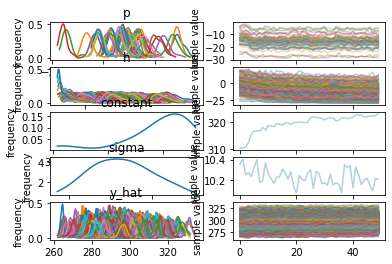

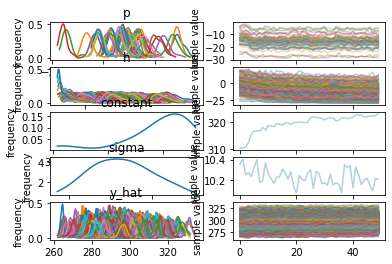

In [5]:
# full stan code ran on bigger data set- took about 10 minutes

mlm_code = """
data {
    int<lower=0> N; 
  int<lower=1,upper=50> players[N];
  int<lower=1,upper=200> hole[N];
  vector[N] dist;
}
transformed data {}
parameters {
    vector<lower=-30,upper=30>[49] p;
    vector<lower=-30,upper=30>[199] h;
    real<lower=0> constant;
    real<lower=0> sigma;
}
transformed parameters {
   vector[N] y_hat;
   
    for (i in 1:N){
      if (players[i]==1 && hole[i]==1){
          y_hat[i] <- constant;
      }
      else if (players[i]==1){
          y_hat[i] <- constant + h[hole[i]-1];
      }
      else if (hole[i]==1){
          y_hat[i] <- constant + p[players[i]-1];
      }
      else{
    y_hat[i] <- constant + h[hole[i]-1]+ p[players[i]-1];
     }
    }  
     
     }   
model {
       sigma ~ normal(0,1);
    
    dist ~ normal(y_hat, sigma);
}
"""

mlm_data = {    'N': len(bigData['Distance']),
             'players': players1 +1 ,
             'hole': holes +1,
             'dist': bigData['Distance']
            }

fit1 = pystan.stan(model_code=mlm_code, data=mlm_data, iter=100, chains=1)

print("test")
la1 = fit1.extract(permuted=True)  # return a dictionary of arrays

## return an array of three dimensions: iterations, chains, parameters
a1 = fit1.extract(permuted=False)
print(fit1)
fit1.plot()